# AlphaNN

We studied the success of AlphaFold 2 and attempted to incorporate its architectural design into our previously described model ingeniously. AlphaFold 2 incorporates neural network architectures and training procedures that are guided by the evolutionary, physical, and geometric constraints of protein structures.

We chose to integrate GAT and GCN layers as the attention-based and non-attention-based components, respectively, in our subnetwork called AlphaNN. The aim is to take advantage of the respective strengths of both models. Specifically, GAT layers are proficient in modeling the node-to-node relationships in the graph, while GCN layers are well-suited for capturing the global graph structure.

Another notable technique utilized in their model involves reinforcing the concept of iterative refinement, termed recycling, which could be integrated into our solubility prediction model, such as AlphaNN and 1D-CNN.

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
import pandas as pd

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [18]:
from model.alpha.AlphaGNN import AlphaGNN

AbstractModel.set_seed(2387)
num_heads = 4

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = AlphaGNN(
        task_type="regression",
        # AlphaGNN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        recycle=3,
        # hidden_feats=[64, 64 * num_heads],
        allow_zero_in_degree=False,
        gat_num_heads=num_heads,
        gat_feat_drop=0.,
        gat_attn_drop=0.,
        gat_alpha=0,
        gat_residual=True,
        gat_agg_mode="flatten",
        gat_bias=True,
        gcn_norm="both",
        gcn_residual=True,
        gcn_batchnorm=False,
        gcn_dropout=0.13108904159657686,
        recycle_alpha=0.7,
        predictor_hidden_feats=128,
        predictor_dropout=0.,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.007319939418114051,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=800, min_epoch=200, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 30%|███       | 240/800 [00:22<00:53, 10.53it/s, loss: 0.467 rmse: 1.323]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 31%|███       | 249/800 [00:25<00:55,  9.96it/s, loss: 0.444 rmse: 1.271]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 30%|███       | 242/800 [00:25<00:57,  9.67it/s, loss: 0.470 rmse: 1.114]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 31%|███       | 246/800 [00:23<00:53, 10.33it/s, loss: 0.463 rmse: 1.241]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 28%|██▊       | 224/800 [00:22<00:58,  9.81it/s, loss: 0.490 rmse: 1.446]


In [19]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [13]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 0.8519135057187208
TST : R^2 0.6060292570459613


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (AlphaNN)\nRMSE: 0.852, $R^2$: 0.606')

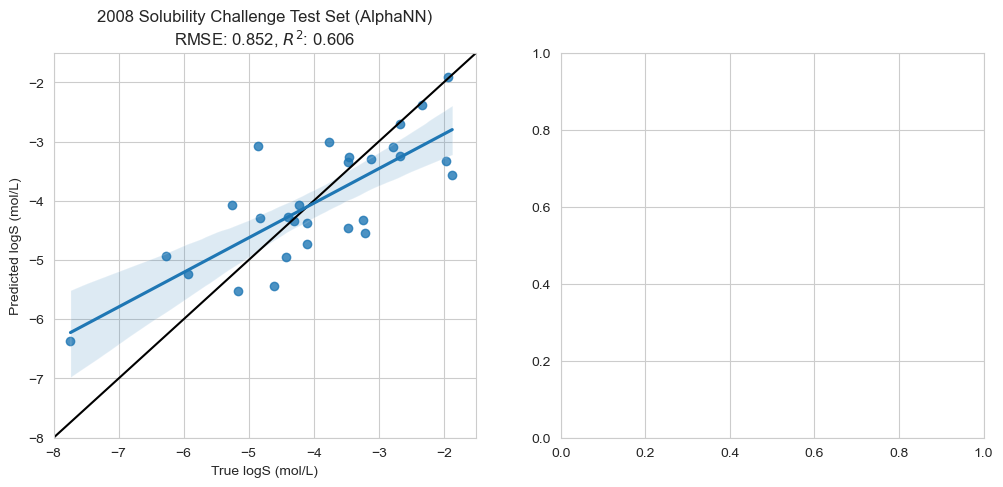

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "AlphaNN"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")